# Unsupervised Learning Trading Strategy

* Download/Load SP500 stocks prices data.
* Calculate different features and indicators on each stock.
* Aggregate on monthly level and filter top 150 most liquid stocks.
* Calculate Monthly Returns for different time-horizons.
* Download Fama-French Factors and Calculate Rolling Factor Betas.
* For each month fit a K-Means Clustering Algorithm to group similar assets based on their features.
* For each month select assets based on the cluster and form a portfolio based on Efficient Frontier max sharpe ratio optimization.
* Visualize Portfolio returns and compare to SP500 returns.

## 1. Download/Load SP500 stocks prices data.

In [1]:
from statsmodels.regression.rolling import RollingOLS
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import pandas_ta
import warnings
warnings.filterwarnings('ignore')

sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]

sp500['Symbol'] = sp500['Symbol'].str.replace('.', '-')

symbols_list = sp500['Symbol'].unique().tolist()

end_date = '2024-09-29'

start_date = pd.to_datetime(end_date)-pd.DateOffset(365*8)

df = yf.download(tickers=symbols_list,
                 start=start_date,
                 end=end_date).stack()

df.index.names = ['date', 'ticker']

df.columns = df.columns.str.lower()

df

[*********************100%***********************]  503 of 503 completed


Price                              adj close       close        high  \
date                      ticker                                       
2016-10-03 00:00:00+00:00 A        44.379704   47.139999   47.230000   
                          AAPL     25.946959   28.129999   28.262501   
                          ABBV     44.792015   63.230000   63.290001   
                          ABT      36.756302   42.549999   42.580002   
                          ACGL     26.306667   26.306667   26.530001   
...                                      ...         ...         ...   
2024-09-27 00:00:00+00:00 XYL     134.509995  134.509995  136.289993   
                          YUM     139.919998  139.919998  140.020004   
                          ZBH     108.220001  108.220001  110.190002   
                          ZBRA    368.600006  368.600006  374.029999   
                          ZTS     194.809998  194.809998  197.509995   

Price                                    low        open      volume  
date                      ticker                                      
2016-10-03 00:00:00+00:00 A        46.820000   46.820000   1538800.0  
                          AAPL     28.070000   28.177500  86807200.0  
                          ABBV     62.250000   63.020000   4239600.0  
                          ABT      41.880001   42.060001   5947400.0  
                          ACGL     26.256666   26.486668   1049400.0  
...                                      ...         ...         ...  
2024-09-27 00:00:00+00:00 XYL     133.779999  134.660004    691300.0  
                          YUM     136.990005  137.520004   2778300.0  
                          ZBH     108.190002  108.769997   1166200.0  
                          ZBRA    368.269989  372.299988    213600.0  
                          ZTS     194.419998  195.649994   1343700.0  

[989817 rows x 6 columns]

## 2. Calculate features and technical indicators for each stock.

* Garman-Klass Volatility
* RSI
* Bollinger Bands
* ATR
* MACD
* Dollar Volume

\begin{equation}
\text{Garman-Klass Volatility} = \frac{(\ln(\text{High}) - \ln(\text{Low}))^2}{2} - (2\ln(2) - 1)(\ln(\text{Adj Close}) - \ln(\text{Open}))^2
\end{equation}

In [2]:
df['garman_klass_vol'] = ((np.log(df['high'])-np.log(df['low']))**2)/2-(2*np.log(2)-1)*((np.log(df['adj close'])-np.log(df['open']))**2)

df['rsi'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.rsi(close=x, length=20))

df['bb_low'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,0])
                                                          
df['bb_mid'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,1])
                                                          
df['bb_high'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,2])

def compute_atr(stock_data):
    atr = pandas_ta.atr(high=stock_data['high'],
                        low=stock_data['low'],
                        close=stock_data['close'],
                        length=14)
    return atr.sub(atr.mean()).div(atr.std())

df['atr'] = df.groupby(level=1, group_keys=False).apply(compute_atr)

def compute_macd(close):
    macd = pandas_ta.macd(close=close, length=20).iloc[:,0]
    return macd.sub(macd.mean()).div(macd.std())

df['macd'] = df.groupby(level=1, group_keys=False)['adj close'].apply(compute_macd)

df['dollar_volume'] = (df['adj close']*df['volume'])/1e6

df

Price                              adj close       close        high  \
date                      ticker                                       
2016-10-03 00:00:00+00:00 A        44.379704   47.139999   47.230000   
                          AAPL     25.946959   28.129999   28.262501   
                          ABBV     44.792015   63.230000   63.290001   
                          ABT      36.756302   42.549999   42.580002   
                          ACGL     26.306667   26.306667   26.530001   
...                                      ...         ...         ...   
2024-09-27 00:00:00+00:00 XYL     134.509995  134.509995  136.289993   
                          YUM     139.919998  139.919998  140.020004   
                          ZBH     108.220001  108.220001  110.190002   
                          ZBRA    368.600006  368.600006  374.029999   
                          ZTS     194.809998  194.809998  197.509995   

Price                                    low        open      volume  \
date                      ticker                                       
2016-10-03 00:00:00+00:00 A        46.820000   46.820000   1538800.0   
                          AAPL     28.070000   28.177500  86807200.0   
                          ABBV     62.250000   63.020000   4239600.0   
                          ABT      41.880001   42.060001   5947400.0   
                          ACGL     26.256666   26.486668   1049400.0   
...                                      ...         ...         ...   
2024-09-27 00:00:00+00:00 XYL     133.779999  134.660004    691300.0   
                          YUM     136.990005  137.520004   2778300.0   
                          ZBH     108.190002  108.769997   1166200.0   
                          ZBRA    368.269989  372.299988    213600.0   
                          ZTS     194.419998  195.649994   1343700.0   

Price                             garman_klass_vol        rsi    bb_low  \
date                      ticker                                          
2016-10-03 00:00:00+00:00 A              -0.001069        NaN       NaN   
                          AAPL           -0.002604        NaN       NaN   
                          ABBV           -0.044893        NaN       NaN   
                          ABT            -0.006881        NaN       NaN   
                          ACGL            0.000036        NaN       NaN   
...                                            ...        ...       ...   
2024-09-27 00:00:00+00:00 XYL             0.000172  52.810998  4.849547   
                          YUM             0.000124  62.536185  4.867805   
                          ZBH             0.000158  48.599342  4.625674   
                          ZBRA            0.000082  64.223784  5.759747   
                          ZTS             0.000117  61.511367  5.220925   

Price                               bb_mid   bb_high       atr      macd  \
date                      ticker                                           
2016-10-03 00:00:00+00:00 A            NaN       NaN       NaN       NaN   
                          AAPL         NaN       NaN       NaN       NaN   
                          ABBV         NaN       NaN       NaN       NaN   
                          ABT          NaN       NaN       NaN       NaN   
                          ACGL         NaN       NaN       NaN       NaN   
...                                    ...       ...       ...       ...   
2024-09-27 00:00:00+00:00 XYL     4.891114  4.932681  0.709040  0.069189   
                          YUM     4.902218  4.936632  0.819708  0.109822   
                          ZBH     4.687395  4.749115 -0.754294 -0.305228   
                          ZBRA    5.851378  5.943010  0.094577  1.038838   
                          ZTS     5.258852  5.296779  0.540133  0.910962   

Price                             dollar_volume  
date                      ticker                 
2016-10-03 00:00:00+00:00 A           68.291488  
           

## 3. Aggregate to monthly level and filter top 150 most liquid stocks for each month.

* To reduce training time and experiment with features and strategies, we convert the business-daily data to month-end frequency.

In [3]:
last_cols = [c for c in df.columns.unique(0) if c not in ['dollar_volume', 'volume', 'open',
                                                          'high', 'low', 'close']]

data = (pd.concat([df.unstack('ticker')['dollar_volume'].resample('M').mean().stack('ticker').to_frame('dollar_volume'),
                   df.unstack()[last_cols].resample('M').last().stack('ticker')],
                  axis=1)).dropna()

data

dollar_volume   adj close  garman_klass_vol  \
date                      ticker                                                
2016-11-30 00:00:00+00:00 A          107.566346   41.404743         -0.002152   
                          AAPL      3498.943357   25.616615         -0.002666   
                          ABBV       400.728804   43.467731         -0.046891   
                          ABT        293.371468   33.095371         -0.009455   
                          ACGL        28.556549   27.573334          0.000048   
...                                         ...         ...               ...   
2024-09-30 00:00:00+00:00 XYL        160.566119  134.509995          0.000172   
                          YUM        287.368688  139.919998          0.000124   
                          ZBH        193.110143  108.220001          0.000158   
                          ZBRA       121.973536  368.600006          0.000082   
                          ZTS        369.222766  194.809998          0.000117   

                                        rsi    bb_low    bb_mid   bb_high  \
date                      ticker                                            
2016-11-30 00:00:00+00:00 A       42.962755  3.727742  3.770327  3.812911   
                          AAPL    46.393440  3.248344  3.277408  3.306472   
                          ABBV    50.060869  3.713227  3.787363  3.861499   
                          ABT     38.338456  3.525170  3.561617  3.598063   
                          ACGL    65.110567  3.285027  3.324037  3.363047   
...                                     ...       ...       ...       ...   
2024-09-30 00:00:00+00:00 XYL     52.810998  4.849547  4.891114  4.932681   
                          YUM     62.536185  4.867805  4.902218  4.936632   
                          ZBH     48.599342  4.625674  4.687395  4.749115   
                          ZBRA    64.223784  5.759747  5.851378  5.943010   
                          ZTS     61.511367  5.220925  5.258852  5.296779   

                                       atr      macd  
date                      ticker                      
2016-11-30 00:00:00+00:00 A      -1.185026 -0.366633  
                          AAPL   -1.272280 -0.375125  
                          ABBV   -0.794040 -0.358754  
                          ABT    -1.212304 -0.631263  
                          ACGL   -1.214654  0.023070  
...                                    ...       ...  
2024-09-30 00:00:00+00:00 XYL     0.709040  0.069189  
                          YUM     0.819708  0.109822  
                          ZBH    -0.754294 -0.305228  
                          ZBRA    0.094577  1.038838  
                          ZTS     0.540133  0.910962  

[46776 rows x 9 columns]

In [4]:
data['dollar_volume'] = (data.loc[:, 'dollar_volume'].unstack('ticker').rolling(5*12, min_periods=12).mean().stack())

data['dollar_vol_rank'] = (data.groupby('date')['dollar_volume'].rank(ascending=False))

data = data[data['dollar_vol_rank']<150].drop(['dollar_volume', 'dollar_vol_rank'], axis=1)

data

adj close  garman_klass_vol        rsi  \
date                      ticker                                            
2017-10-31 00:00:00+00:00 AAPL     39.667976         -0.001105  69.196630   
                          ABBV     66.876793         -0.036142  55.247847   
                          ABT      48.237450         -0.005677  53.844778   
                          ACN     128.834702         -0.004274  69.365101   
                          ADBE    175.160004          0.000067  70.089319   
...                                      ...               ...        ...   
2024-09-30 00:00:00+00:00 VZ       44.889999          0.000073  65.041488   
                          WFC      55.900002          0.000043  51.187900   
                          WMT      79.779999          0.000036  63.358678   
                          XOM     115.820000          0.000182  51.821142   
                          ZTS     194.809998          0.000117  61.511367   

                                    bb_low    bb_mid   bb_high       atr  \
date                      ticker                                           
2017-10-31 00:00:00+00:00 AAPL    3.593605  3.640476  3.687347 -1.168054   
                          ABBV    4.187696  4.234050  4.280405  0.164683   
                          ABT     3.887384  3.910952  3.934519 -1.279397   
                          ACN     4.798335  4.838013  4.877691 -1.238438   
                          ADBE    4.951759  5.089292  5.226825 -1.229132   
...                                    ...       ...       ...       ...   
2024-09-30 00:00:00+00:00 VZ      3.741780  3.796610  3.851439 -0.385753   
                          WFC     3.961944  4.026840  4.091735  1.559348   
                          WMT     4.345042  4.380543  4.416044  1.795657   
                          XOM     4.706781  4.745506  4.784230  1.071074   
                          ZTS     5.220925  5.258852  5.296779  0.540133   

                                      macd  
date                      ticker            
2017-10-31 00:00:00+00:00 AAPL   -0.099406  
                          ABBV    0.325229  
                          ABT     0.223817  
                          ACN     0.294483  
                          ADBE    0.555741  
...                                    ...  
2024-09-30 00:00:00+00:00 VZ      1.827322  
                          WFC    -0.241016  
                          WMT     2.646431  
                          XOM    -0.152388  
                          ZTS     0.910962  

[12516 rows x 8 columns]

In [5]:
last_cols = [c for c in df.columns.unique(0) if c not in ['dollar_volume', 'volume', 'open',
                                                          'high', 'low', 'close']]

data = (pd.concat([df.unstack('ticker')['dollar_volume'].resample('M').mean().stack('ticker').to_frame('dollar_volume'),
                   df.unstack()[last_cols].resample('M').last().stack('ticker')],
                  axis=1)).dropna()

data

dollar_volume   adj close  garman_klass_vol  \
date                      ticker                                                
2016-11-30 00:00:00+00:00 A          107.566346   41.404743         -0.002152   
                          AAPL      3498.943357   25.616615         -0.002666   
                          ABBV       400.728804   43.467731         -0.046891   
                          ABT        293.371468   33.095371         -0.009455   
                          ACGL        28.556549   27.573334          0.000048   
...                                         ...         ...               ...   
2024-09-30 00:00:00+00:00 XYL        160.566119  134.509995          0.000172   
                          YUM        287.368688  139.919998          0.000124   
                          ZBH        193.110143  108.220001          0.000158   
                          ZBRA       121.973536  368.600006          0.000082   
                          ZTS        369.222766  194.809998          0.000117   

                                        rsi    bb_low    bb_mid   bb_high  \
date                      ticker                                            
2016-11-30 00:00:00+00:00 A       42.962755  3.727742  3.770327  3.812911   
                          AAPL    46.393440  3.248344  3.277408  3.306472   
                          ABBV    50.060869  3.713227  3.787363  3.861499   
                          ABT     38.338456  3.525170  3.561617  3.598063   
                          ACGL    65.110567  3.285027  3.324037  3.363047   
...                                     ...       ...       ...       ...   
2024-09-30 00:00:00+00:00 XYL     52.810998  4.849547  4.891114  4.932681   
                          YUM     62.536185  4.867805  4.902218  4.936632   
                          ZBH     48.599342  4.625674  4.687395  4.749115   
                          ZBRA    64.223784  5.759747  5.851378  5.943010   
                          ZTS     61.511367  5.220925  5.258852  5.296779   

                                       atr      macd  
date                      ticker                      
2016-11-30 00:00:00+00:00 A      -1.185026 -0.366633  
                          AAPL   -1.272280 -0.375125  
                          ABBV   -0.794040 -0.358754  
                          ABT    -1.212304 -0.631263  
                          ACGL   -1.214654  0.023070  
...                                    ...       ...  
2024-09-30 00:00:00+00:00 XYL     0.709040  0.069189  
                          YUM     0.819708  0.109822  
                          ZBH    -0.754294 -0.305228  
                          ZBRA    0.094577  1.038838  
                          ZTS     0.540133  0.910962  

[46776 rows x 9 columns]

* Calculate 5-year rolling average of dollar volume for each stocks before filtering.

In [6]:
data['dollar_volume'] = (data.loc[:, 'dollar_volume'].unstack('ticker').rolling(5*12, min_periods=12).mean().stack())

data['dollar_vol_rank'] = (data.groupby('date')['dollar_volume'].rank(ascending=False))

data = data[data['dollar_vol_rank']<150].drop(['dollar_volume', 'dollar_vol_rank'], axis=1)

data

adj close  garman_klass_vol        rsi  \
date                      ticker                                            
2017-10-31 00:00:00+00:00 AAPL     39.667976         -0.001105  69.196630   
                          ABBV     66.876793         -0.036142  55.247847   
                          ABT      48.237450         -0.005677  53.844778   
                          ACN     128.834702         -0.004274  69.365101   
                          ADBE    175.160004          0.000067  70.089319   
...                                      ...               ...        ...   
2024-09-30 00:00:00+00:00 VZ       44.889999          0.000073  65.041488   
                          WFC      55.900002          0.000043  51.187900   
                          WMT      79.779999          0.000036  63.358678   
                          XOM     115.820000          0.000182  51.821142   
                          ZTS     194.809998          0.000117  61.511367   

                                    bb_low    bb_mid   bb_high       atr  \
date                      ticker                                           
2017-10-31 00:00:00+00:00 AAPL    3.593605  3.640476  3.687347 -1.168054   
                          ABBV    4.187696  4.234050  4.280405  0.164683   
                          ABT     3.887384  3.910952  3.934519 -1.279397   
                          ACN     4.798335  4.838013  4.877691 -1.238438   
                          ADBE    4.951759  5.089292  5.226825 -1.229132   
...                                    ...       ...       ...       ...   
2024-09-30 00:00:00+00:00 VZ      3.741780  3.796610  3.851439 -0.385753   
                          WFC     3.961944  4.026840  4.091735  1.559348   
                          WMT     4.345042  4.380543  4.416044  1.795657   
                          XOM     4.706781  4.745506  4.784230  1.071074   
                          ZTS     5.220925  5.258852  5.296779  0.540133   

                                      macd  
date                      ticker            
2017-10-31 00:00:00+00:00 AAPL   -0.099406  
                          ABBV    0.325229  
                          ABT     0.223817  
                          ACN     0.294483  
                          ADBE    0.555741  
...                                    ...  
2024-09-30 00:00:00+00:00 VZ      1.827322  
                          WFC    -0.241016  
                          WMT     2.646431  
                          XOM    -0.152388  
                          ZTS     0.910962  

[12516 rows x 8 columns]

## 4. Calculate Monthly Returns for different time horizons as features.

* To capture time series dynamics that reflect, for example, momentum patterns, we compute historical returns using the method .pct_change(lag), that is, returns over various monthly periods as identified by lags.

In [7]:
def calculate_returns(df):

    outlier_cutoff = 0.005

    lags = [1, 2, 3, 6, 9, 12]

    for lag in lags:

        df[f'return_{lag}m'] = (df['adj close']
                              .pct_change(lag)
                              .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                                     upper=x.quantile(1-outlier_cutoff)))
                              .add(1)
                              .pow(1/lag)
                              .sub(1))
    return df
    
    
data = data.groupby(level=1, group_keys=False).apply(calculate_returns).dropna()

data 

adj close  garman_klass_vol        rsi  \
date                      ticker                                            
2018-10-31 00:00:00+00:00 AAPL     52.135616         -0.000440  50.232922   
                          ABBV     59.937759         -0.033812  30.334042   
                          ABT      62.445831         -0.003318  51.539062   
                          ACN     145.218872         -0.001825  44.756078   
                          ADBE    245.759995          0.000288  46.518480   
...                                      ...               ...        ...   
2024-09-30 00:00:00+00:00 VRTX    462.880005          0.000068  43.105640   
                          VZ       44.889999          0.000073  65.041488   
                          WFC      55.900002          0.000043  51.187900   
                          WMT      79.779999          0.000036  63.358678   
                          XOM     115.820000          0.000182  51.821142   

                                    bb_low    bb_mid   bb_high       atr  \
date                      ticker                                           
2018-10-31 00:00:00+00:00 AAPL    3.937352  3.975716  4.014081 -0.530545   
                          ABBV    4.099873  4.221550  4.343227  0.320270   
                          ABT     4.108511  4.150519  4.192527 -0.217395   
                          ACN     4.930141  4.994854  5.059567 -0.433016   
                          ADBE    5.452778  5.520491  5.588203  0.209231   
...                                    ...       ...       ...       ...   
2024-09-30 00:00:00+00:00 VRTX    6.121560  6.161621  6.201681  1.372397   
                          VZ      3.741780  3.796610  3.851439 -0.385753   
                          WFC     3.961944  4.026840  4.091735  1.559348   
                          WMT     4.345042  4.380543  4.416044  1.795657   
                          XOM     4.706781  4.745506  4.784230  1.071074   

                                      macd  return_1m  return_2m  return_3m  \
date                      ticker                                              
2018-10-31 00:00:00+00:00 AAPL   -0.452422  -0.030478  -0.019453   0.048955   
                          ABBV   -1.775561  -0.168082  -0.089585  -0.051576   
                          ABT    -0.504118  -0.056387   0.017674   0.018394   
                          ACN    -0.890461  -0.065449  -0.030053  -0.000564   
                          ADBE   -0.676730  -0.089609  -0.034267   0.001469   
...                                    ...        ...        ...        ...   
2024-09-30 00:00:00+00:00 VRTX   -1.429837  -0.066567  -0.033691  -0.004171   
                          VZ      1.827322   0.074438   0.052544   0.034253   
                          WFC    -0.241016  -0.043954  -0.025718  -0.017496   
                          WMT     2.646431   0.033018   0.079634   0.057205   
                          XOM    -0.152388  -0.017975  -0.007778   0.004705   

                                  return_6m  return_9m  return_12m  
date                      ticker                                    
2018-10-31 00:00:00+00:00 AAPL     0.049216   0.031518    0.023037  
                          ABBV    -0.031893  -0.035910   -0.009087  
                          ABT      0.030307   0.013075    0.021747  
                          ACN      0.008483  -0.000163    0.010026  
                          ADBE     0.017396   0.023294    0.028623  
...                                     ...        ...         ...  
2024-09-30 00:00:00+00:00 VRTX     0.017139   0.014428    0.024121  
                          VZ       0.016772   0.025153    0.029510  
                          WFC     -0.003800   0.016536    0.028964  
                          WMT      0.049051   0.047915    0.033843  
                          XOM      0.002084   0.019343    0.001616  

[10367 rows x 14 columns]

## 5. Download Fama-French Factors and Calculate Rolling Factor Betas.

* We will introduce the Fama—French data to estimate the exposure of assets to common risk factors using linear regression.

* The five Fama—French factors, namely market risk, size, value, operating profitability, and investment have been shown empirically to explain asset returns and are commonly used to assess the risk/return profile of portfolios. Hence, it is natural to include past factor exposures as financial features in models.

* We can access the historical factor returns using the pandas-datareader and estimate historical exposures using the RollingOLS rolling linear regression.

In [8]:
factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3',
                               'famafrench',
                               start='2010')[0].drop('RF', axis=1)

factor_data.index = factor_data.index.to_timestamp()

factor_data = factor_data.resample('M').last().div(100)

factor_data.index.name = 'date'

# Convert the first level (date) of the MultiIndex to be timezone-naive
data['return_1m'].index = data['return_1m'].index.set_levels(
    data['return_1m'].index.levels[0].tz_convert(None), level=0
)

factor_data = factor_data.join(data['return_1m']).sort_index()

factor_data

Mkt-RF     SMB    HML     RMW     CMA  return_1m
date       ticker                                                  
2018-10-31 AAPL   -0.0768 -0.0445  0.034  0.0095  0.0358  -0.030478
           ABBV   -0.0768 -0.0445  0.034  0.0095  0.0358  -0.168082
           ABT    -0.0768 -0.0445  0.034  0.0095  0.0358  -0.056387
           ACN    -0.0768 -0.0445  0.034  0.0095  0.0358  -0.065449
           ADBE   -0.0768 -0.0445  0.034  0.0095  0.0358  -0.089609
...                   ...     ...    ...     ...     ...        ...
2024-07-31 VRTX    0.0124  0.0833  0.057  0.0017  0.0043   0.057604
           VZ      0.0124  0.0833  0.057  0.0017  0.0043  -0.001379
           WFC     0.0124  0.0833  0.057  0.0017  0.0043  -0.000842
           WMT     0.0124  0.0833  0.057  0.0017  0.0043   0.013735
           XOM     0.0124  0.0833  0.057  0.0017  0.0043   0.030142

[10083 rows x 6 columns]

* Filter out stocks with less than 10 months of data.

In [9]:
observations = factor_data.groupby(level=1).size()

valid_stocks = observations[observations >= 10]

factor_data = factor_data[factor_data.index.get_level_values('ticker').isin(valid_stocks.index)]

factor_data

Mkt-RF     SMB    HML     RMW     CMA  return_1m
date       ticker                                                  
2018-10-31 AAPL   -0.0768 -0.0445  0.034  0.0095  0.0358  -0.030478
           ABBV   -0.0768 -0.0445  0.034  0.0095  0.0358  -0.168082
           ABT    -0.0768 -0.0445  0.034  0.0095  0.0358  -0.056387
           ACN    -0.0768 -0.0445  0.034  0.0095  0.0358  -0.065449
           ADBE   -0.0768 -0.0445  0.034  0.0095  0.0358  -0.089609
...                   ...     ...    ...     ...     ...        ...
2024-07-31 VRTX    0.0124  0.0833  0.057  0.0017  0.0043   0.057604
           VZ      0.0124  0.0833  0.057  0.0017  0.0043  -0.001379
           WFC     0.0124  0.0833  0.057  0.0017  0.0043  -0.000842
           WMT     0.0124  0.0833  0.057  0.0017  0.0043   0.013735
           XOM     0.0124  0.0833  0.057  0.0017  0.0043   0.030142

[10049 rows x 6 columns]

* Calculate Rolling Factor Betas.

In [10]:
betas = (factor_data.groupby(level=1,
                            group_keys=False)
         .apply(lambda x: RollingOLS(endog=x['return_1m'], 
                                     exog=sm.add_constant(x.drop('return_1m', axis=1)),
                                     window=min(24, x.shape[0]),
                                     min_nobs=len(x.columns)+1)
         .fit(params_only=True)
         .params
         .drop('const', axis=1)))

betas

Mkt-RF       SMB       HML       RMW       CMA
date       ticker                                                  
2018-10-31 AAPL         NaN       NaN       NaN       NaN       NaN
           ABBV         NaN       NaN       NaN       NaN       NaN
           ABT          NaN       NaN       NaN       NaN       NaN
           ACN          NaN       NaN       NaN       NaN       NaN
           ADBE         NaN       NaN       NaN       NaN       NaN
...                     ...       ...       ...       ...       ...
2024-07-31 VRTX    0.569025  0.648189 -0.392910  0.648667  0.140270
           VZ      0.689696 -0.844718  0.631432  0.297128 -0.473038
           WFC     1.111663 -0.130669  1.182282 -0.816393 -0.613398
           WMT     0.476748  0.123753 -0.164167  0.869365  0.094606
           XOM     0.630903 -0.090536  0.297811  0.609450  1.041608

[10049 rows x 5 columns]

* Join the rolling factors data to the main features dataframe.

Converting the index type of betas from timestamp to pd.DateTime with UTC 
for the join operation to take place

In [11]:
betas.index = [pd.to_datetime(betas.index.get_level_values(0)).tz_localize('UTC'), betas.index.get_level_values(1)]

In [12]:
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']

data = (data.join(betas.groupby('ticker').shift()))

data.loc[:, factors] = data.groupby('ticker', group_keys=False)[factors].apply(lambda x: x.fillna(x.mean()))

data = data.drop('adj close', axis=1)

data = data.dropna()

data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 10124 entries, (Timestamp('2018-10-31 00:00:00+0000', tz='UTC'), 'AAPL') to (Timestamp('2024-09-30 00:00:00+0000', tz='UTC'), 'XOM')
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   garman_klass_vol  10124 non-null  float64
 1   rsi               10124 non-null  float64
 2   bb_low            10124 non-null  float64
 3   bb_mid            10124 non-null  float64
 4   bb_high           10124 non-null  float64
 5   atr               10124 non-null  float64
 6   macd              10124 non-null  float64
 7   return_1m         10124 non-null  float64
 8   return_2m         10124 non-null  float64
 9   return_3m         10124 non-null  float64
 10  return_6m         10124 non-null  float64
 11  return_9m         10124 non-null  float64
 12  return_12m        10124 non-null  float64
 13  Mkt-RF            10124 non-null  float64
 14  SMB               10124 non

## 6. For each month fit a K-Means Clustering Algorithm to group similar assets based on their features.

### K-Means Clustering

In [13]:
from sklearn.cluster import KMeans

def get_clusters(df):
    df['cluster'] = KMeans(n_clusters=4,
                           random_state=0,
                           init='random').fit(df).labels_
    return df

data = data.dropna().groupby('date', group_keys=False).apply(get_clusters)

data

garman_klass_vol        rsi    bb_low  \
date                      ticker                                          
2018-10-31 00:00:00+00:00 AAPL           -0.000440  50.232922  3.937352   
                          ABBV           -0.033812  30.334042  4.099873   
                          ABT            -0.003318  51.539062  4.108511   
                          ACN            -0.001825  44.756078  4.930141   
                          ADBE            0.000288  46.518480  5.452778   
...                                            ...        ...       ...   
2024-09-30 00:00:00+00:00 VRTX            0.000068  43.105640  6.121560   
                          VZ              0.000073  65.041488  3.741780   
                          WFC             0.000043  51.187900  3.961944   
                          WMT             0.000036  63.358678  4.345042   
                          XOM             0.000182  51.821142  4.706781   

                                    bb_mid   bb_high       atr      macd  \
date                      ticker                                           
2018-10-31 00:00:00+00:00 AAPL    3.975716  4.014081 -0.530545 -0.452422   
                          ABBV    4.221550  4.343227  0.320270 -1.775561   
                          ABT     4.150519  4.192527 -0.217395 -0.504118   
                          ACN     4.994854  5.059567 -0.433016 -0.890461   
                          ADBE    5.520491  5.588203  0.209231 -0.676730   
...                                    ...       ...       ...       ...   
2024-09-30 00:00:00+00:00 VRTX    6.161621  6.201681  1.372397 -1.429837   
                          VZ      3.796610  3.851439 -0.385753  1.827322   
                          WFC     4.026840  4.091735  1.559348 -0.241016   
                          WMT     4.380543  4.416044  1.795657  2.646431   
                          XOM     4.745506  4.784230  1.071074 -0.152388   

                                  return_1m  return_2m  return_3m  return_6m  \
date                      ticker                                               
2018-10-31 00:00:00+00:00 AAPL    -0.030478  -0.019453   0.048955   0.049216   
                          ABBV    -0.168082  -0.089585  -0.051576  -0.031893   
                          ABT     -0.056387   0.017674   0.018394   0.030307   
                          ACN     -0.065449  -0.030053  -0.000564   0.008483   
                          ADBE    -0.089609  -0.034267   0.001469   0.017396   
...                                     ...        ...        ...        ...   
2024-09-30 00:00:00+00:00 VRTX    -0.066567  -0.033691  -0.004171   0.017139   
                          VZ       0.074438   0.052544   0.034253   0.016772   
                          WFC     -0.043954  -0.025718  -0.017496  -0.003800   
                          WMT      0.033018   0.079634   0.057205   0.049051   
                          XOM     -0.017975  -0.007778   0.004705   0.002084   

                                  return_9m  return_12m    Mkt-RF       SMB  \
date                      ticker                                              
2018-10-31 00:00:00+00:00 AAPL     0.031518    0.023037  1.312685 -0.302059   
                          ABBV    -0.035910   -0.009087  0.514879  0.396825   
                          ABT      0.013075    0.021747  0.768178 -0.073813   
                          ACN     -0.000163    0.010026  1.212128 -0.206746   
                          ADBE     0.023294    0.028623  1.280003 -0.528485   
...                                     ...         ...       ...       ...   
2024-09-30 00:00:00+00:00 VRTX     0.014428    0.024121  0.497444  0.054516   
                          VZ       0.025153    0.029510  0.462854 -0.463056   
                          WFC      0.016536    0.028964  1.104116 -0.092380   
                          WMT      0.047915    0.033843  0.629748 -0.366181   
                          XOM      0.019343    0.001616  1.045460  0.107149   



In [14]:
def plot_clusters(data):

    cluster_0 = data[data['cluster']==0]
    cluster_1 = data[data['cluster']==1]
    cluster_2 = data[data['cluster']==2]
    cluster_3 = data[data['cluster']==3]

    plt.scatter(cluster_0.iloc[:,6] , cluster_0.iloc[:,1] , color = 'red', label='cluster 0')
    plt.scatter(cluster_1.iloc[:,6] , cluster_1.iloc[:,1] , color = 'green', label='cluster 1')
    plt.scatter(cluster_2.iloc[:,6] , cluster_2.iloc[:,1] , color = 'blue', label='cluster 2')
    plt.scatter(cluster_3.iloc[:,6] , cluster_3.iloc[:,1] , color = 'black', label='cluster 3')
    
    plt.legend()
    plt.show()
    return


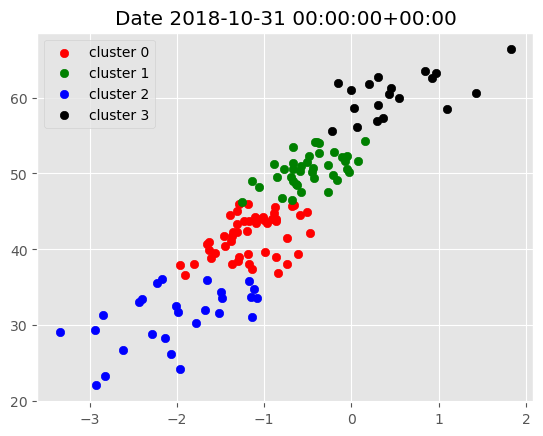

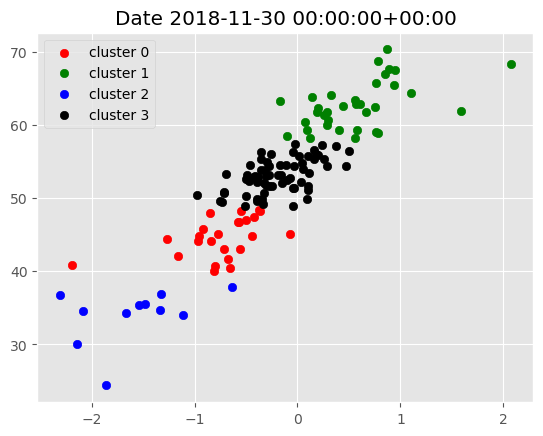

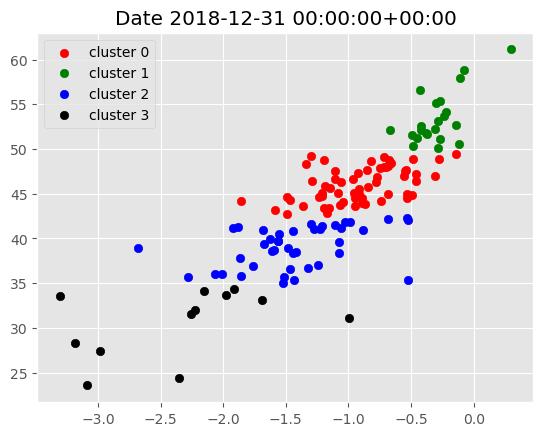

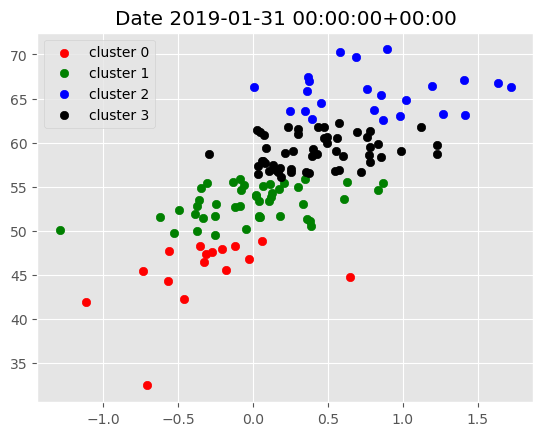

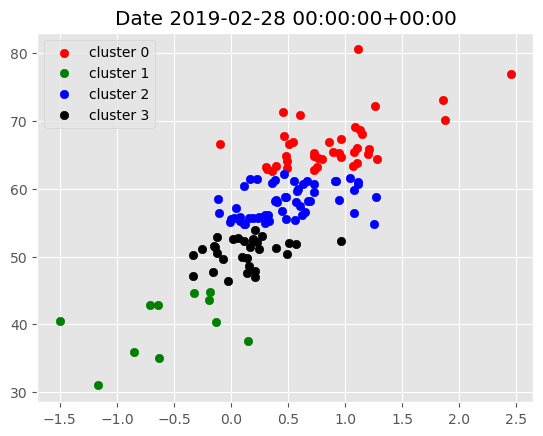

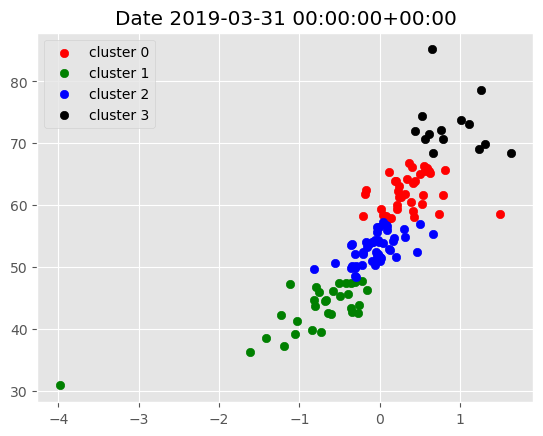

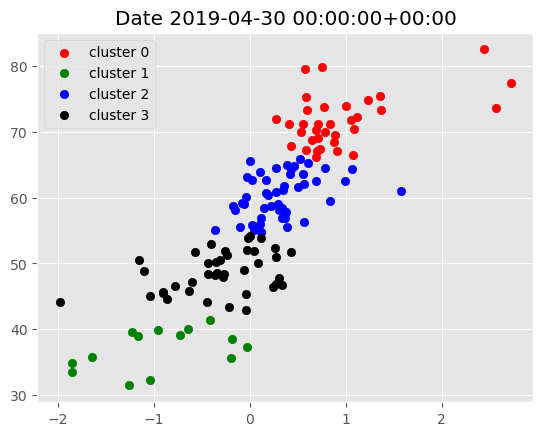

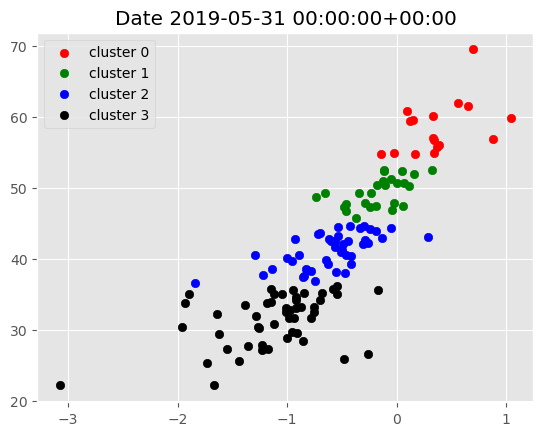

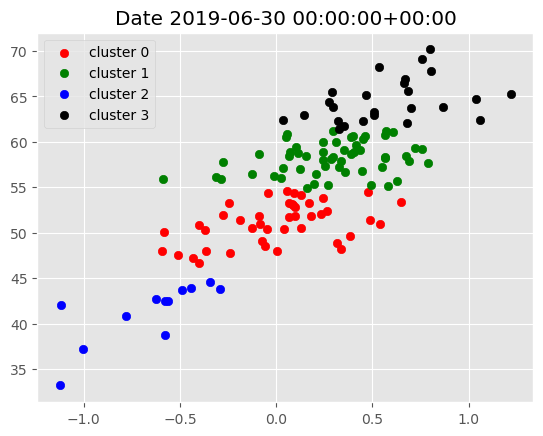

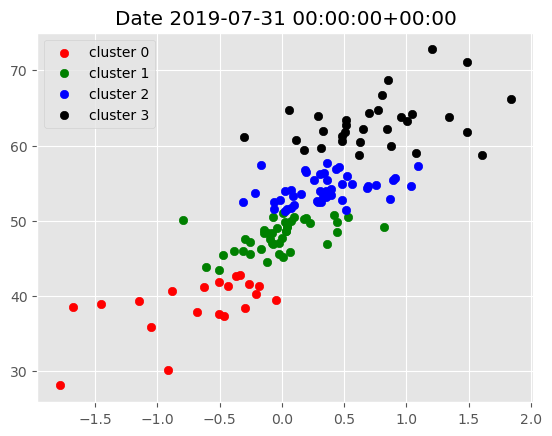

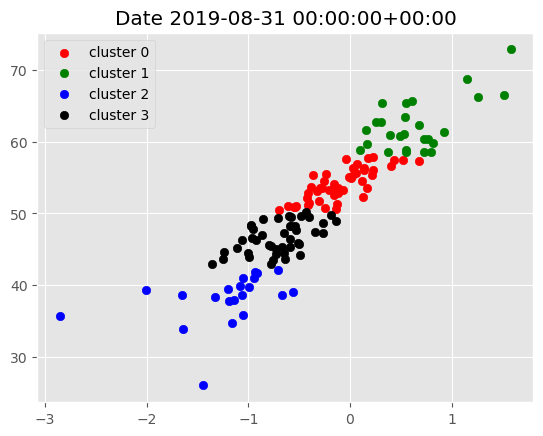

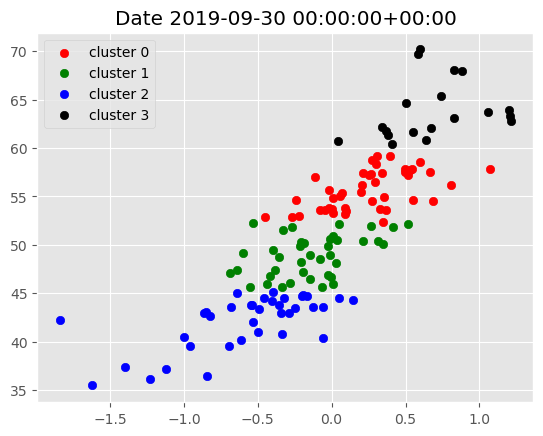

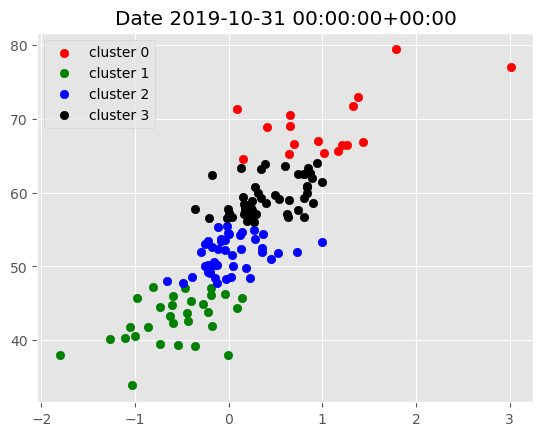

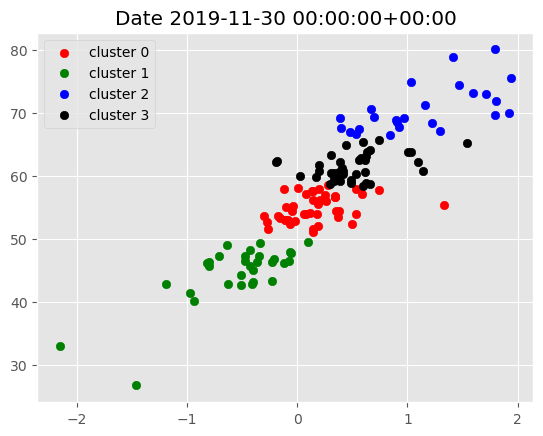

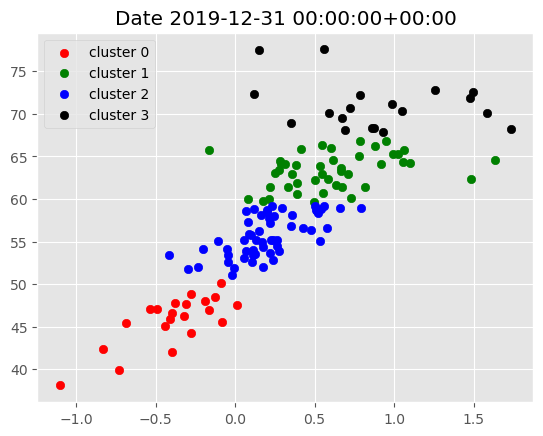

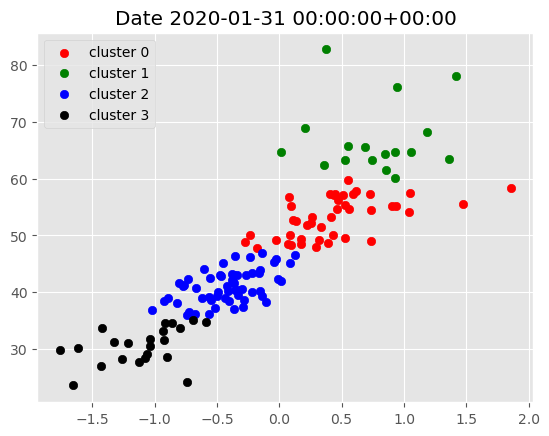

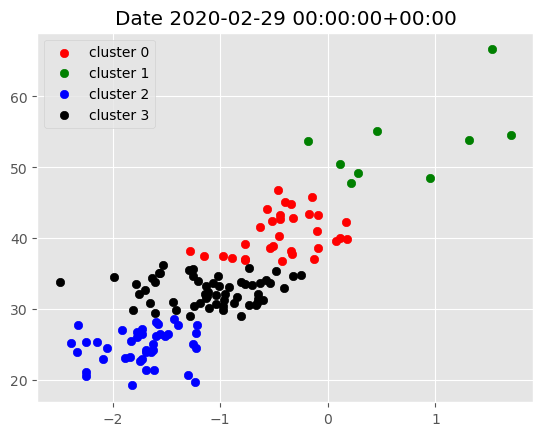

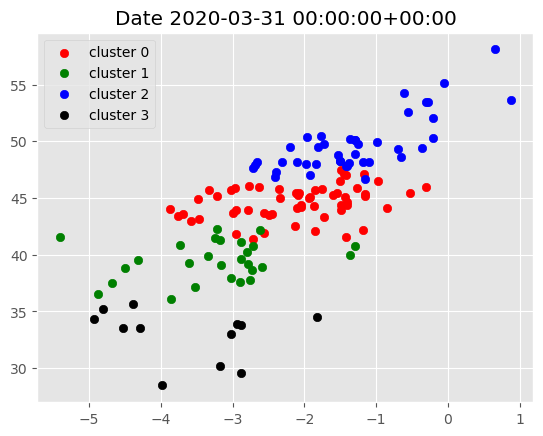

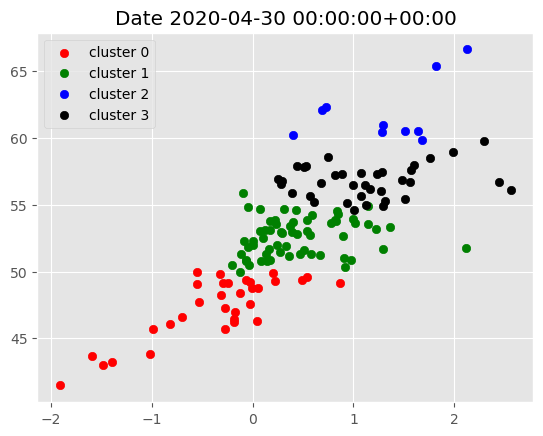

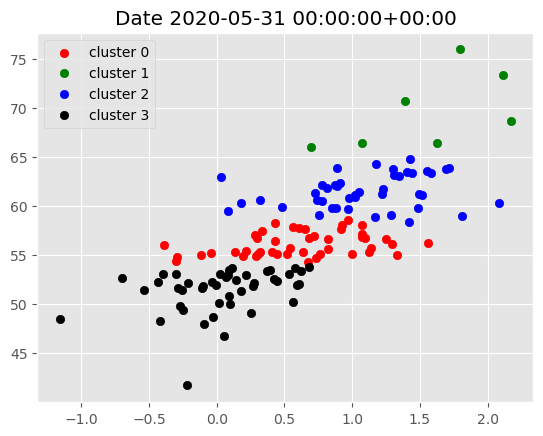

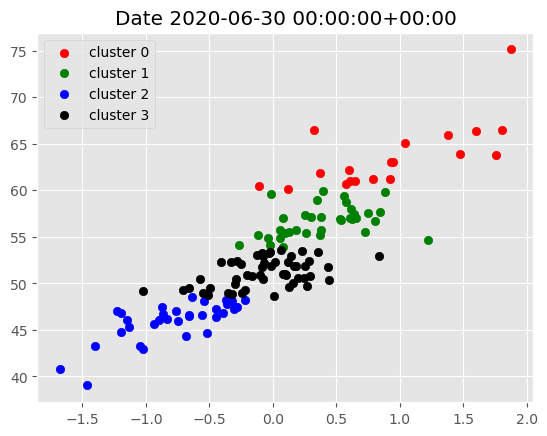

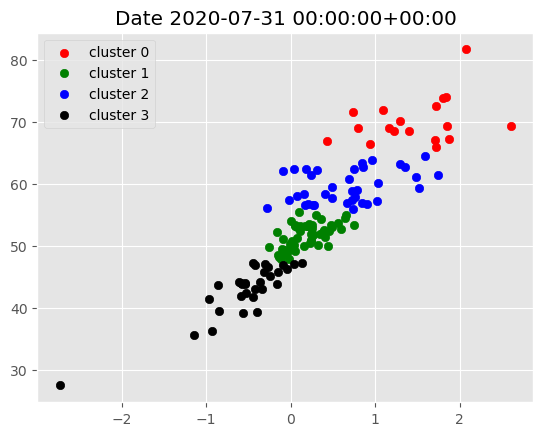

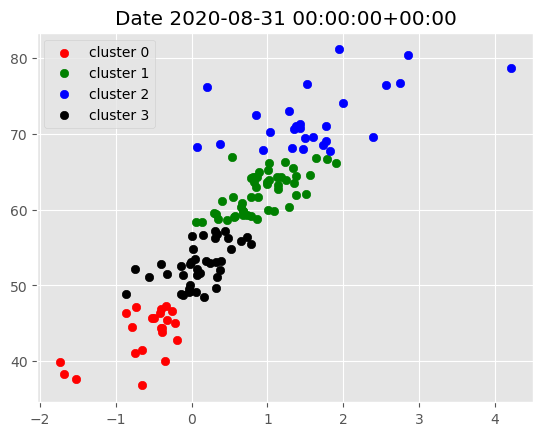

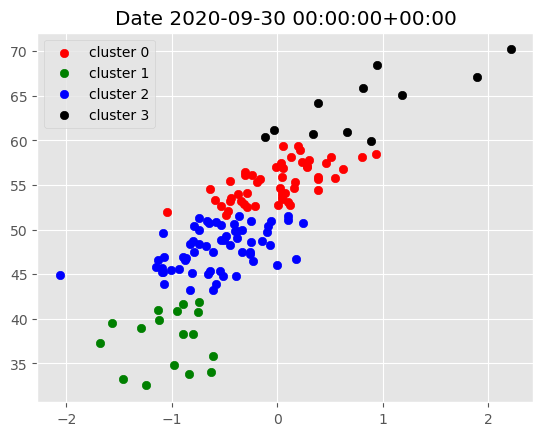

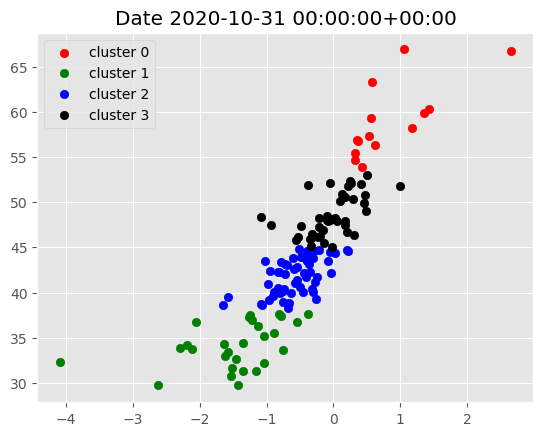

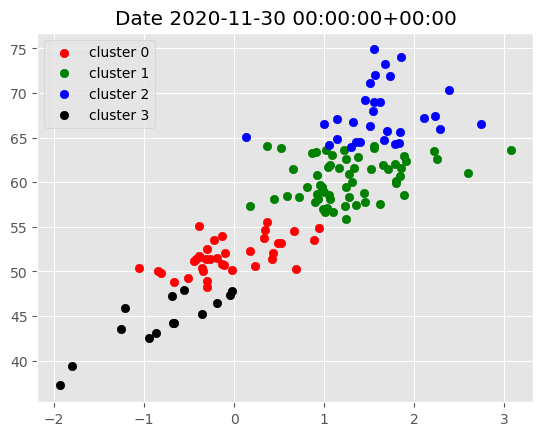

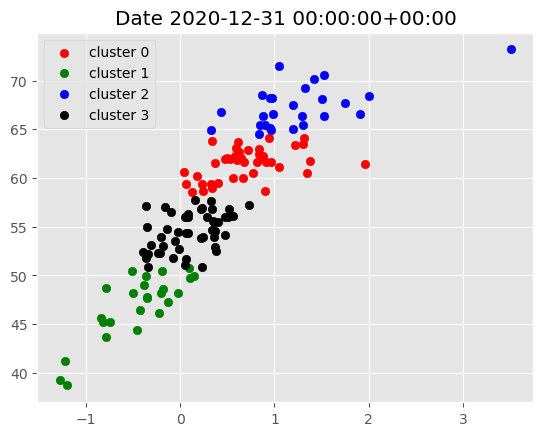

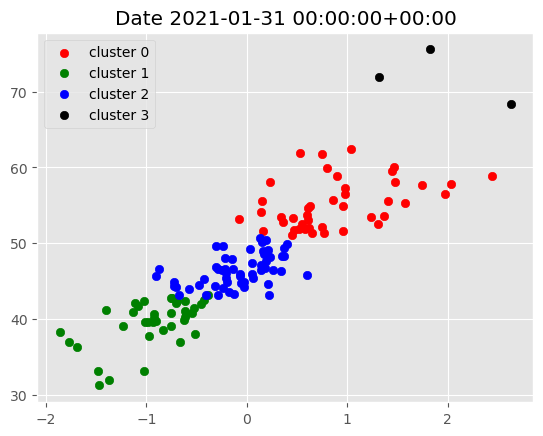

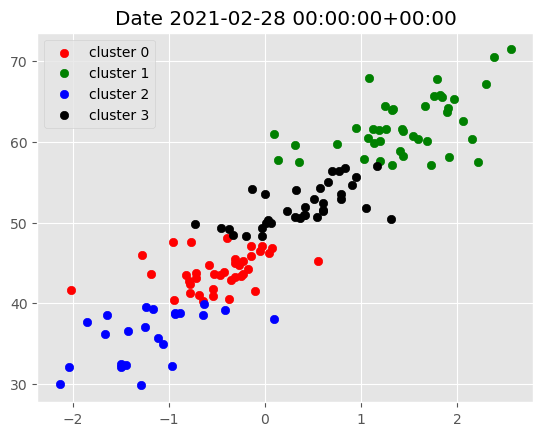

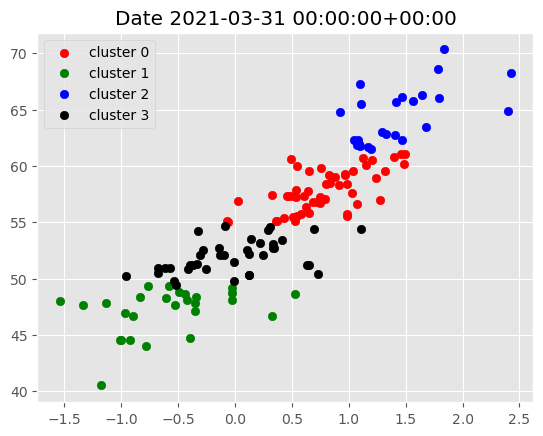

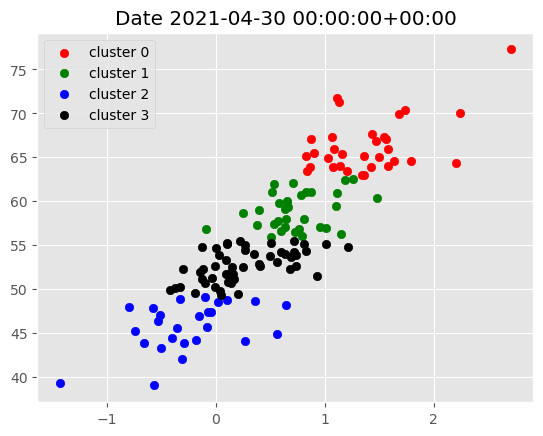

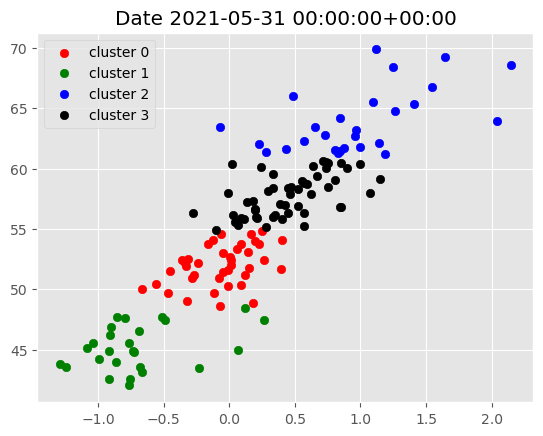

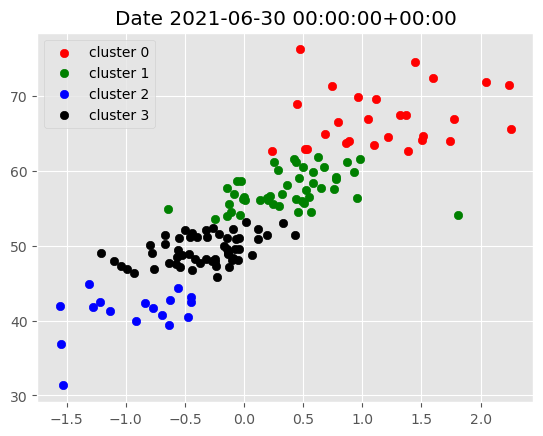

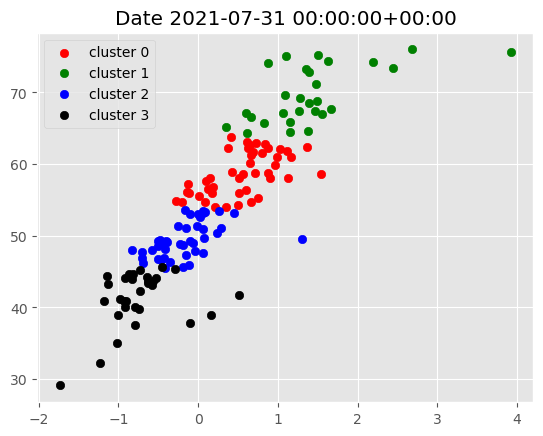

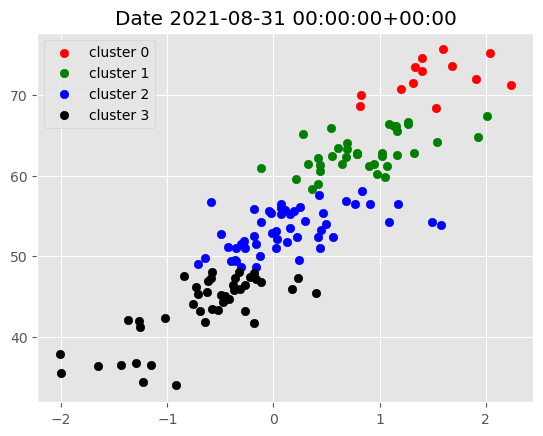

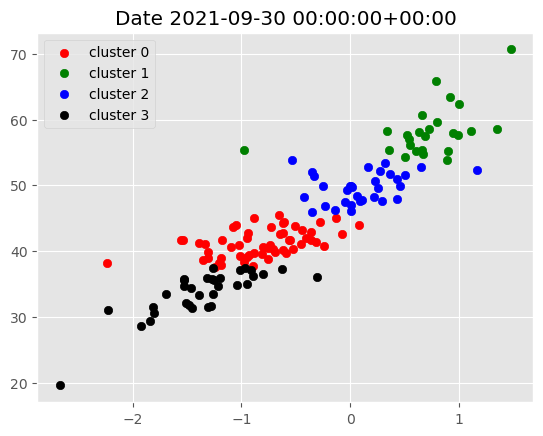

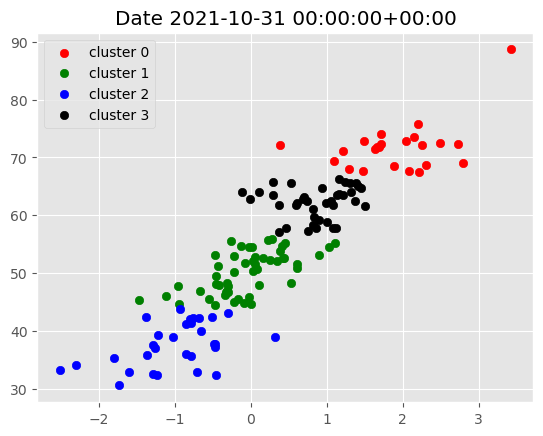

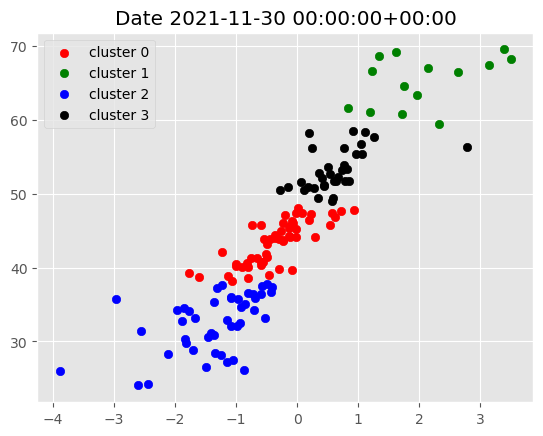

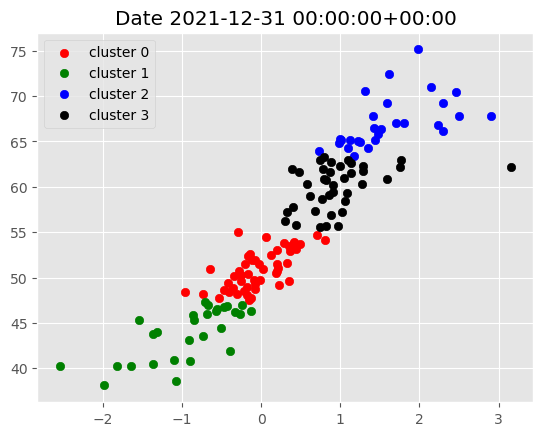

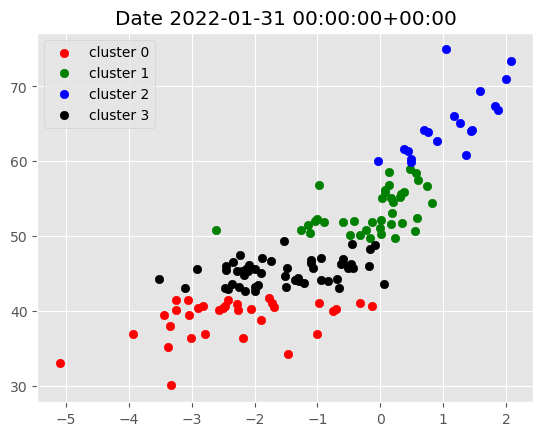

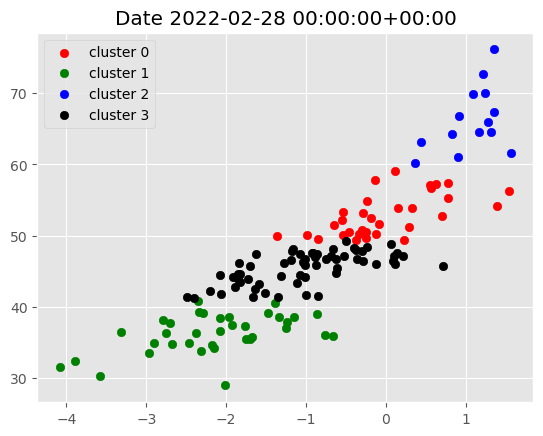

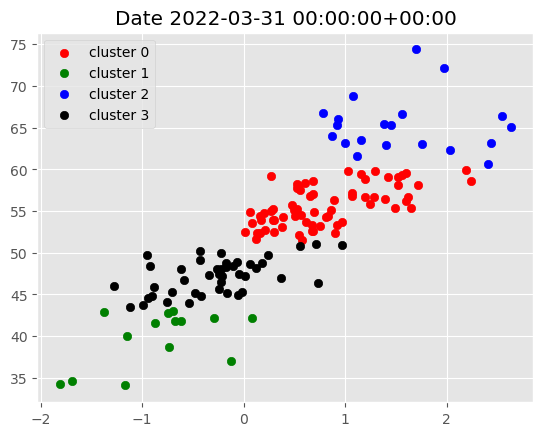

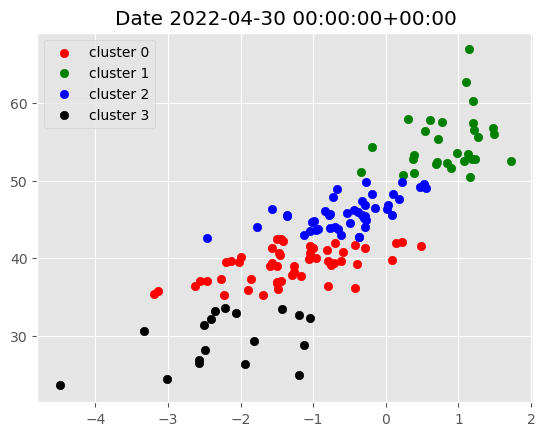

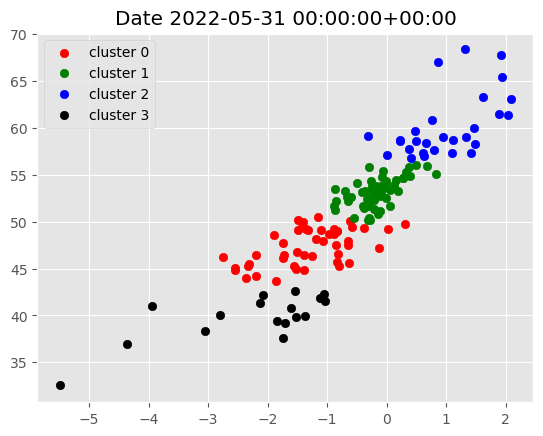

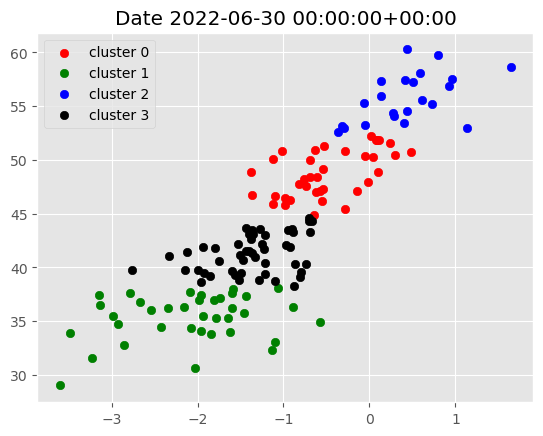

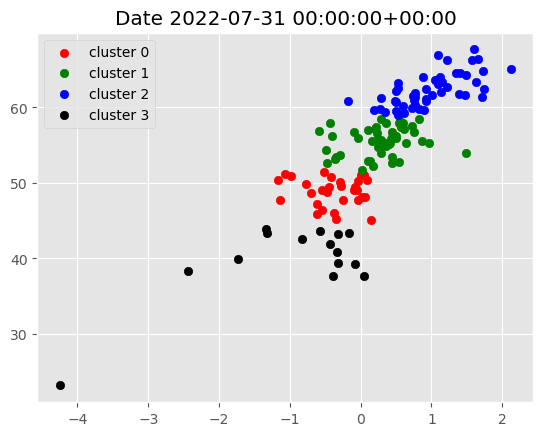

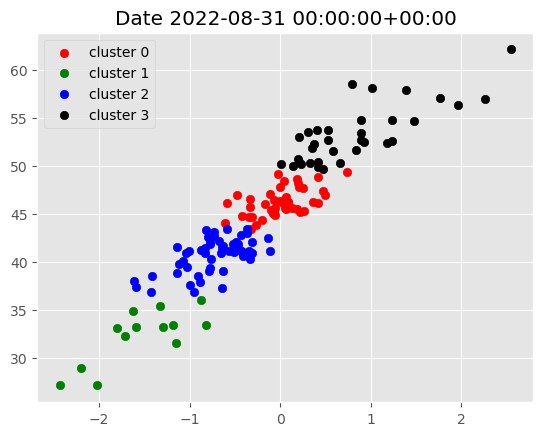

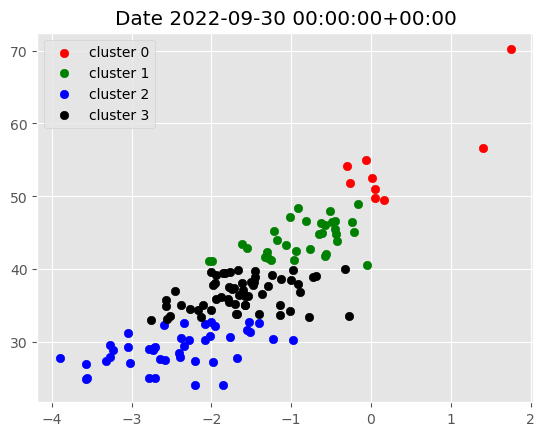

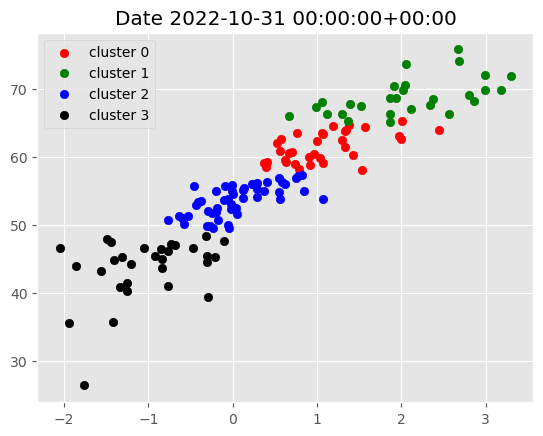

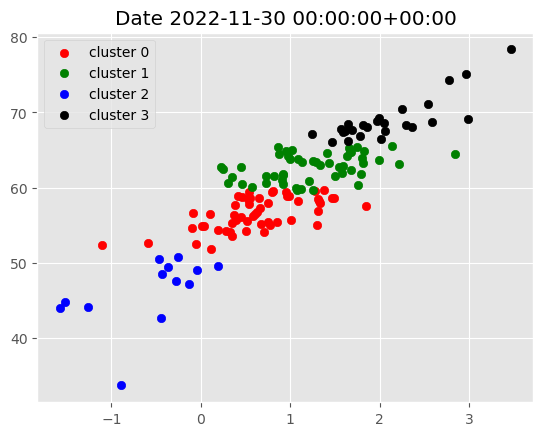

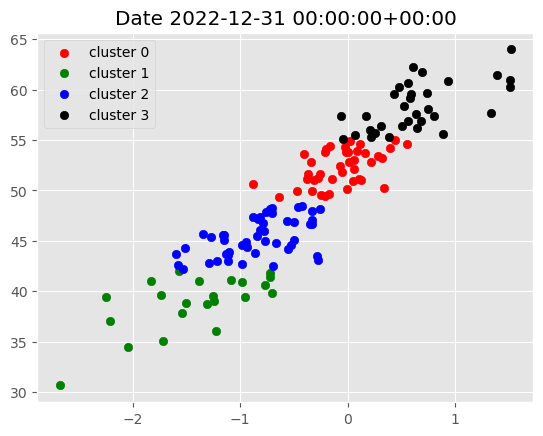

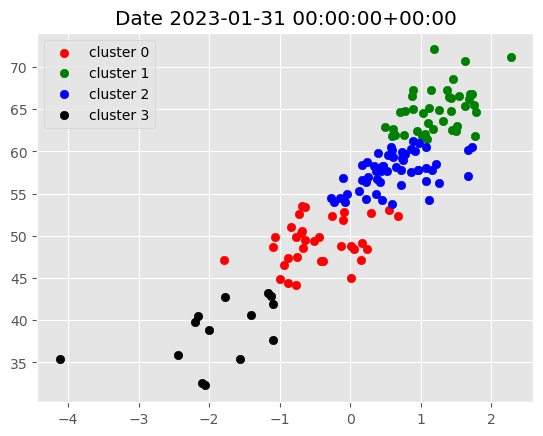

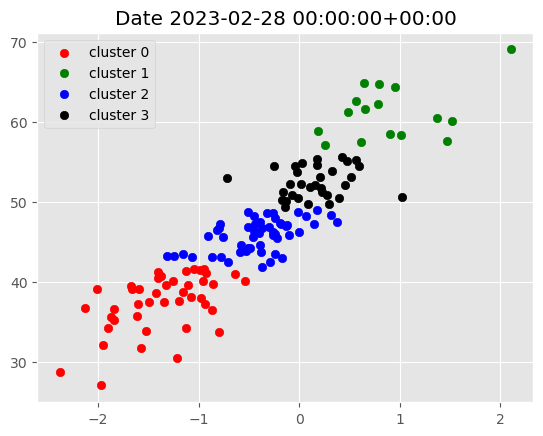

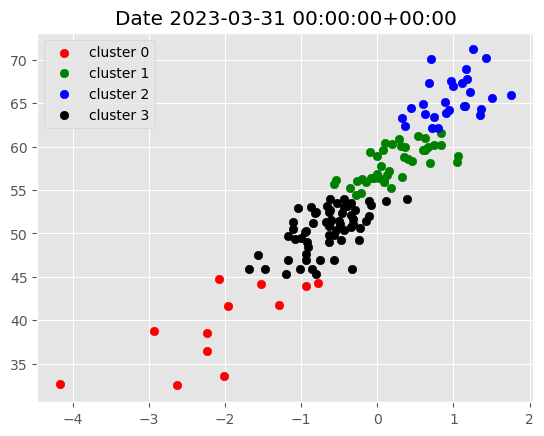

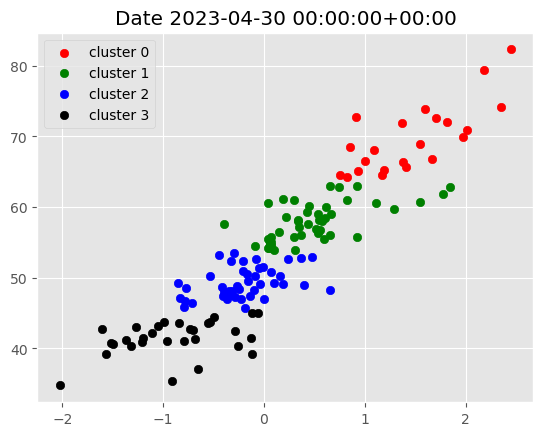

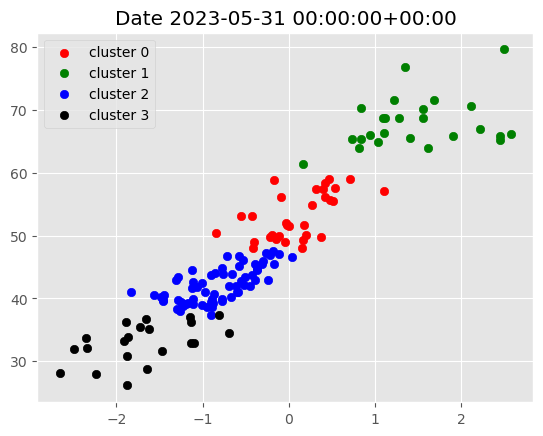

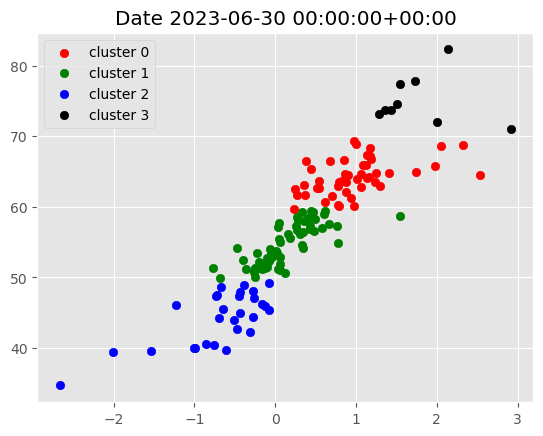

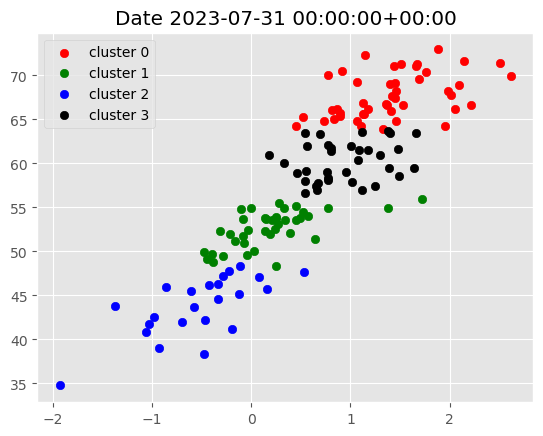

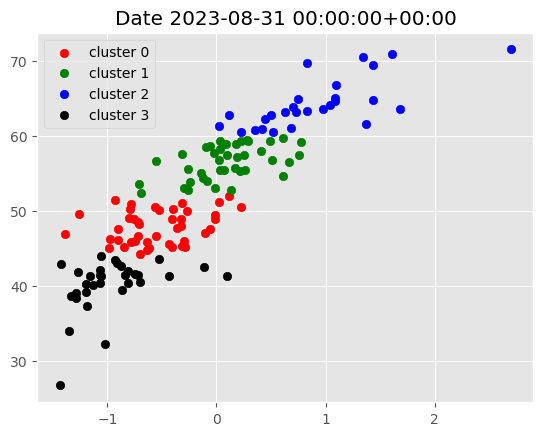

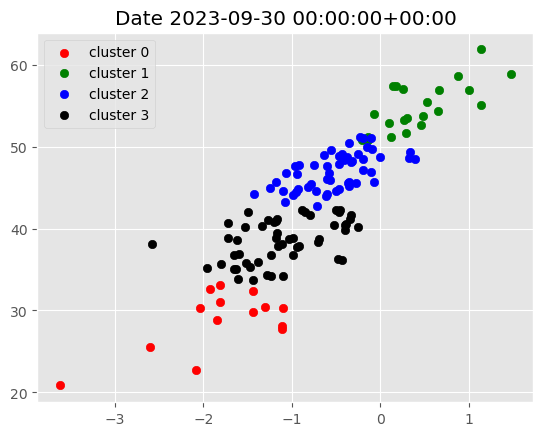

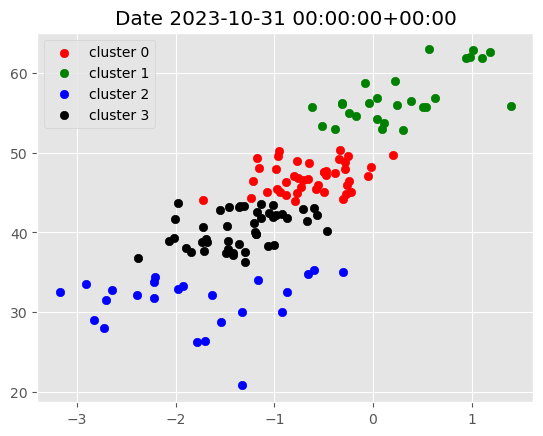

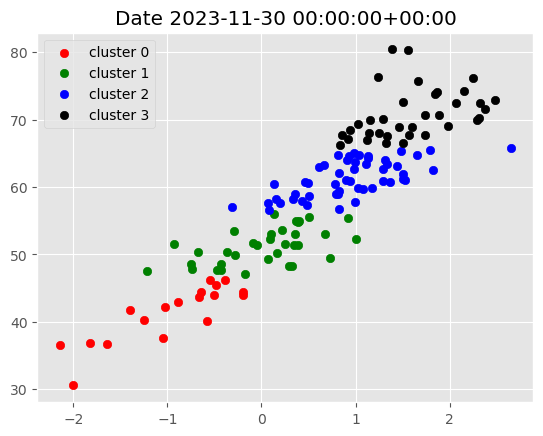

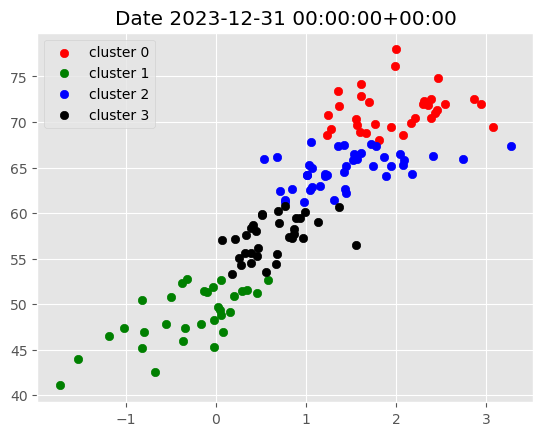

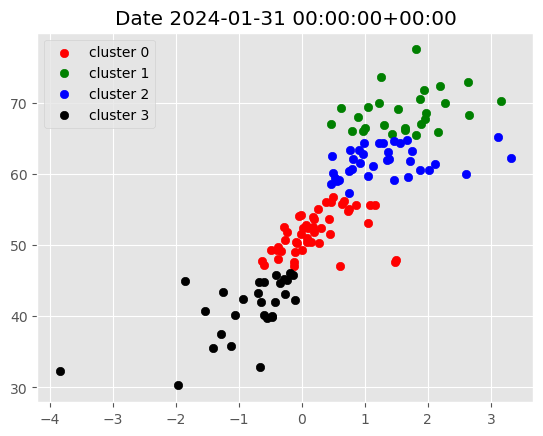

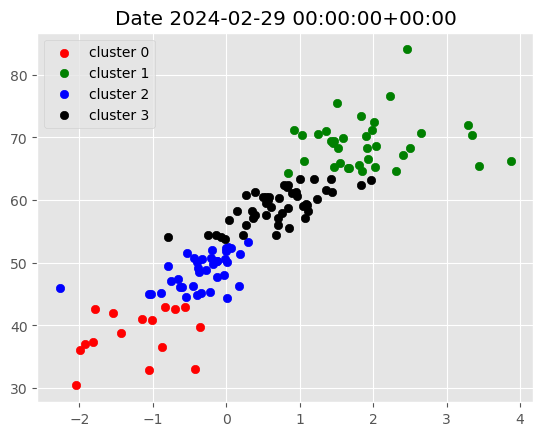

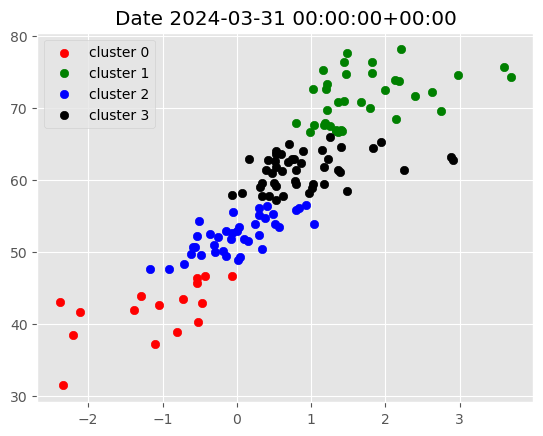

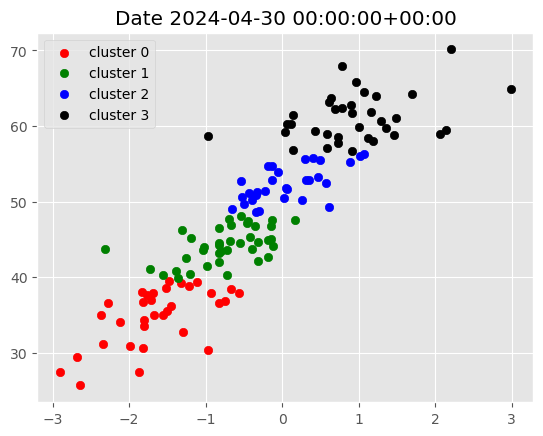

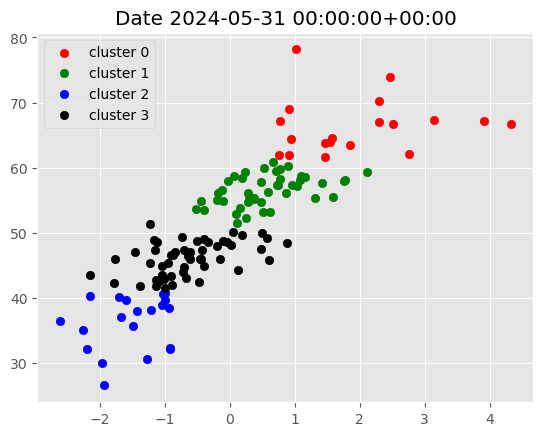

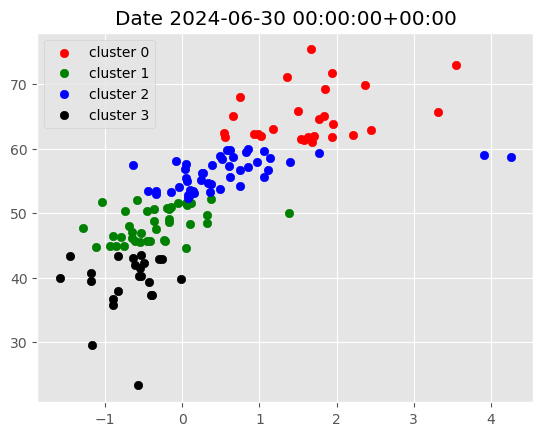

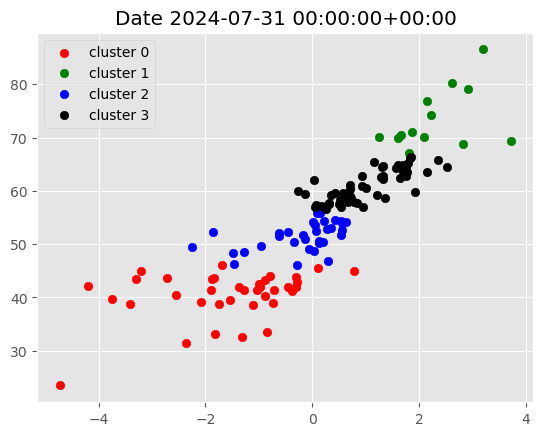

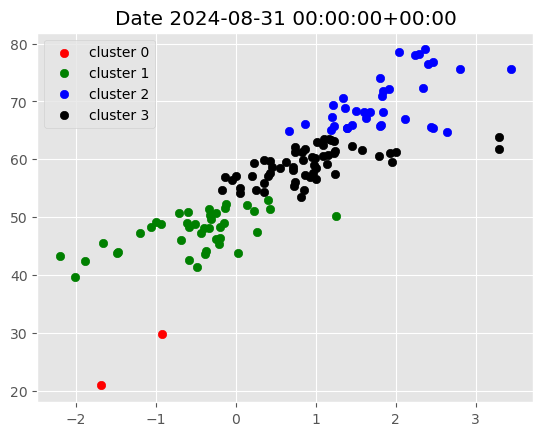

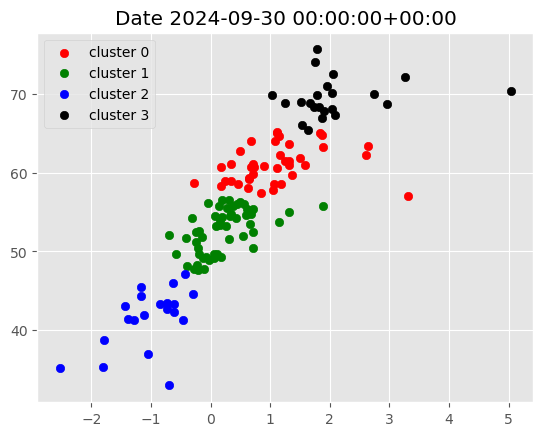

In [15]:
plt.style.use('ggplot')

for i in data.index.get_level_values('date').unique().tolist():
    
    g = data.xs(i, level=0)
    
    plt.title(f'Date {i}')
    
    plot_clusters(g)

### Apply pre-defined centroids.

In [16]:
target_rsi_values = [30, 45, 55, 70]

initial_centroids = np.zeros((len(target_rsi_values), 18))

initial_centroids[:, 1] = target_rsi_values

initial_centroids

array([[ 0., 30.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0., 45.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0., 55.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0., 70.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.]])

## 7. For each month select assets based on the cluster and form a portfolio based on Efficient Frontier max sharpe ratio optimization

* First we will filter only stocks corresponding to the cluster we choose based on our hypothesis.

* Momentum is persistent and my idea would be that stocks clustered around RSI 30 centroid should continue to outperform in the following month - thus I would select stocks corresponding to cluster 3.


In [35]:
filtered_df = data[data['cluster']==0].copy()

filtered_df = filtered_df.reset_index(level=1)

filtered_df.index = filtered_df.index+pd.DateOffset(1)

filtered_df = filtered_df.reset_index().set_index(['date', 'ticker'])

dates = filtered_df.index.get_level_values('date').unique().tolist()

fixed_dates = {}

for d in dates:
    
    fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d, level=0).index.tolist()
    
fixed_dates

{'2018-11-01': ['ACN',
  'ADI',
  'ADSK',
  'AMAT',
  'AMGN',
  'AMZN',
  'AVGO',
  'AXP',
  'AZO',
  'BAC',
  'BLK',
  'BRK-B',
  'C',
  'COP',
  'CRM',
  'CSX',
  'CVS',
  'CVX',
  'DE',
  'DHR',
  'EBAY',
  'FCX',
  'FDX',
  'GILD',
  'GOOG',
  'GOOGL',
  'HON',
  'HUM',
  'LRCX',
  'MA',
  'MAR',
  'MCK',
  'MDT',
  'META',
  'MMM',
  'MU',
  'NFLX',
  'NKE',
  'NVDA',
  'NXPI',
  'ORLY',
  'QCOM',
  'RTX',
  'SCHW',
  'SHW',
  'T',
  'TXN',
  'UNP',
  'VRTX',
  'XOM'],
 '2018-12-01': ['AIG',
  'AMD',
  'BMY',
  'C',
  'COP',
  'DD',
  'EOG',
  'IBM',
  'LMT',
  'LOW',
  'MAR',
  'MCK',
  'META',
  'MS',
  'MU',
  'NFLX',
  'OXY',
  'PANW',
  'QCOM',
  'RTX',
  'SCHW',
  'STZ',
  'TJX',
  'WDC'],
 '2019-01-01': ['ADBE',
  'ADI',
  'ADP',
  'ADSK',
  'AIG',
  'AMAT',
  'AMD',
  'AMT',
  'AMZN',
  'BA',
  'BDX',
  'BIIB',
  'BKNG',
  'BLK',
  'BMY',
  'BRK-B',
  'CMG',
  'COP',
  'CSCO',
  'CVX',
  'DD',
  'DIS',
  'EBAY',
  'ELV',
  'GE',
  'GM',
  'GOOG',
  'GOOGL',
  'HD',
  'ISRG

### Define portfolio optimization function

* We will define a function which optimizes portfolio weights using PyPortfolioOpt package and EfficientFrontier optimizer to maximize the sharpe ratio.

* To optimize the weights of a given portfolio we would need to supply last 1 year prices to the function.

* Apply single stock weight bounds constraint for diversification (minimum half of equaly weight and maximum 10% of portfolio).

In [36]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

def optimize_weights(prices, lower_bound=0):
    
    returns = expected_returns.mean_historical_return(prices=prices,
                                                      frequency=252)
    
    cov = risk_models.sample_cov(prices=prices,
                                 frequency=252)
    
    ef = EfficientFrontier(expected_returns=returns,
                           cov_matrix=cov,
                           weight_bounds=(lower_bound, .1),
                           solver='SCS')
    
    weights = ef.max_sharpe()
    
    return ef.clean_weights()


* Download Fresh Daily Prices Data only for short listed stocks.

In [37]:
stocks = data.index.get_level_values('ticker').unique().tolist()

new_df = yf.download(tickers=stocks,
                     start=data.index.get_level_values('date').unique()[0]-pd.DateOffset(months=12),
                     end=data.index.get_level_values('date').unique()[-1])

new_df

[*********************100%***********************]  153 of 153 completed


Price                       Adj Close                                      \
Ticker                           AAPL        ABBV         ABT         ACN   
Date                                                                        
2017-10-31 00:00:00+00:00   39.667984   66.876816   48.237469  128.834671   
2017-11-01 00:00:00+00:00   39.163452   68.499634   48.032864  129.377701   
2017-11-02 00:00:00+00:00   39.449749   67.447411   48.361992  129.803040   
2017-11-03 00:00:00+00:00   40.479927   68.403305   49.340439  130.355118   
2017-11-06 00:00:00+00:00   40.890602   68.884964   48.931271  130.255539   
...                               ...         ...         ...         ...   
2024-09-23 00:00:00+00:00  226.470001  193.830002  114.809998  339.209991   
2024-09-24 00:00:00+00:00  227.369995  193.509995  113.339996  339.619995   
2024-09-25 00:00:00+00:00  226.369995  191.259995  112.610001  337.049988   
2024-09-26 00:00:00+00:00  227.520004  191.899994  112.730003  355.809998   
2024-09-27 00:00:00+00:00  227.789993  194.789993  112.430000  349.700012   

Price                                                                      \
Ticker                           ADBE         ADI         ADP        ADSK   
Date                                                                        
2017-10-31 00:00:00+00:00  175.160004   79.939743  100.318520  124.959999   
2017-11-01 00:00:00+00:00  176.250000   79.668304   99.576424  124.779999   
2017-11-02 00:00:00+00:00  180.940002   79.493172   98.661789  124.720001   
2017-11-03 00:00:00+00:00  182.300003   80.386261   96.849739  124.849998   
2017-11-06 00:00:00+00:00  180.800003   80.797783   96.064529  123.820000   
...                               ...         ...         ...         ...   
2024-09-23 00:00:00+00:00  527.869995  226.009995  277.579987  268.459991   
2024-09-24 00:00:00+00:00  524.070007  227.330002  276.640015  269.649994   
2024-09-25 00:00:00+00:00  517.900024  226.639999  275.250000  268.000000   
2024-09-26 00:00:00+00:00  515.380005  232.460007  274.429993  273.359985   
2024-09-27 00:00:00+00:00  515.479980  232.050003  272.880005  271.899994   

Price                                             ...    Volume           \
Ticker                           AIG        ALGN  ...         V      VLO   
Date                                              ...                      
2017-10-31 00:00:00+00:00  53.633965  238.979996  ...   8002500  3231000   
2017-11-01 00:00:00+00:00  53.675472  234.949997  ...   6167300  4097800   
2017-11-02 00:00:00+00:00  53.941105  233.470001  ...   5506600  4972900   
2017-11-03 00:00:00+00:00  51.467350  241.350006  ...   3757600  3390500   
2017-11-06 00:00:00+00:00  51.874111  244.500000  ...   4094700  3326200   
...                              ...         ...  ...       ...      ...   
2024-09-23 00:00:00+00:00  74.300003  253.160004  ...   6505600  2817500   
2024-09-24 00:00:00+00:00  73.419998  249.009995  ...  13690200  3062700   
2024-09-25 00:00:00+00:00  73.019997  242.449997  ...  11671300  3008500   
2024-09-26 00:00:00+00:00  73.120003  249.460007  ...   9552500  6296800   
2024-09-27 00:00:00+00:00  73.339996  254.809998  ...   6508500  2935800   

Price                                                                      \
Ticker                        VRTX        VZ       WBA      WDC       WFC   
Date                                                                        
2017-10-31 00:00:00+00:00  2457100  15910000  12224700  5661000  14619200   
2017-11-01 00:00:00+00:00  2412600  11046600   9702600  3780000  11678300   
2017-11-02 00:00:00+00:00  2050000  13126900   8042600  2605600  15630000   
2017-11-03 00:00:00+00:00  1884900   8038200  14066400  2942700  10049200   
2017-11-06 00:00:00+00:00  1608300  36443300   5949600  3084300  10414900   
...                            ...       ...       ...      ...       ...   
2024-09-23 00:00:00+00:00   975000  18083200  15926200  2908200  14759300   
2024-09

* Calculate daily returns for each stock which could land up in our portfolio.

* Then loop over each month start, select the stocks for the month and calculate their weights for the next month.

* If the maximum sharpe ratio optimization fails for a given month, apply equally-weighted weights.

* Calculated each day portfolio return.

In [38]:
returns_dataframe = np.log(new_df['Adj Close']).diff()

portfolio_df = pd.DataFrame()

for start_date in fixed_dates.keys():
    
    try:

        end_date = (pd.to_datetime(start_date)+pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')

        cols = fixed_dates[start_date]

        optimization_start_date = (pd.to_datetime(start_date)-pd.DateOffset(months=12)).strftime('%Y-%m-%d')

        optimization_end_date = (pd.to_datetime(start_date)-pd.DateOffset(days=1)).strftime('%Y-%m-%d')
        
        optimization_df = new_df[optimization_start_date:optimization_end_date]['Adj Close'][cols]
        
        success = False
        try:
            weights = optimize_weights(prices=optimization_df,
                                   lower_bound=round(1/(len(optimization_df.columns)*2),3))

            weights = pd.DataFrame(weights, index=pd.Series(0))
            
            success = True
        except:
            print(f'Max Sharpe Optimization failed for {start_date}, Continuing with Equal-Weights')
        
        if success==False:
            weights = pd.DataFrame([1/len(optimization_df.columns) for i in range(len(optimization_df.columns))],
                                     index=optimization_df.columns.tolist(),
                                     columns=pd.Series(0)).T
        
        temp_df = returns_dataframe[start_date:end_date]

        temp_df = temp_df.stack().to_frame('return').reset_index(level=0)\
                   .merge(weights.stack().to_frame('weight').reset_index(level=0, drop=True),
                          left_index=True,
                          right_index=True)\
                   .reset_index().set_index(['Date', 'Ticker']).unstack().stack()

        temp_df.index.names = ['date', 'ticker']

        temp_df['weighted_return'] = temp_df['return']*temp_df['weight']

        temp_df = temp_df.groupby(level=0)['weighted_return'].sum().to_frame('Strategy Return')

        portfolio_df = pd.concat([portfolio_df, temp_df], axis=0)
    
    except Exception as e:
        print(e)

portfolio_df = portfolio_df.drop_duplicates()

portfolio_df

Max Sharpe Optimization failed for 2019-02-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2020-05-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2022-10-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2023-04-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2023-12-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2024-09-01, Continuing with Equal-Weights
'return'


,Strategy Return
date,
2018-11-01 00:00:00+00:00,0.019107
2018-11-02 00:00:00+00:00,-0.003901
2018-11-05 00:00:00+00:00,0.002941
2018-11-06 00:00:00+00:00,0.007557
2018-11-07 00:00:00+00:00,0.028123
...,...
2024-09-23 00:00:00+00:00,-0.011765
2024-09-24 00:00:00+00:00,-0.007701
2024-09-25 00:00:00+00:00,-0.006665


## 8. Visualize Portfolio returns and compare to SP500 returns.

In [39]:
spy = yf.download(tickers='SPY',
                  start='2015-01-01',
                  end=dt.date.today())

spy_ret = np.log(spy[['Adj Close']]).diff().dropna().rename({'Adj Close':'SPY Buy&Hold'}, axis=1)

# Ensure both DataFrames have the same time zone
spy_ret.index = spy_ret.index.tz_localize('UTC')

# Now merge the DataFrames
portfolio_df = portfolio_df.merge(spy_ret, left_index=True, right_index=True)


portfolio_df

[*********************100%***********************]  1 of 1 completed


,Strategy Return,SPY Buy&Hold
2018-11-01 00:00:00+00:00,0.019107,0.010586
2018-11-02 00:00:00+00:00,-0.003901,-0.005940
2018-11-05 00:00:00+00:00,0.002941,0.005502
2018-11-06 00:00:00+00:00,0.007557,0.006308
2018-11-07 00:00:00+00:00,0.028123,0.021183
...,...,...
2024-09-23 00:00:00+00:00,-0.011765,0.002496
2024-09-24 00:00:00+00:00,-0.007701,0.002857
2024-09-25 00:00:00+00:00,-0.006665,-0.002208
2024-09-26 00:00:00+00:00,0.017929,0.003957


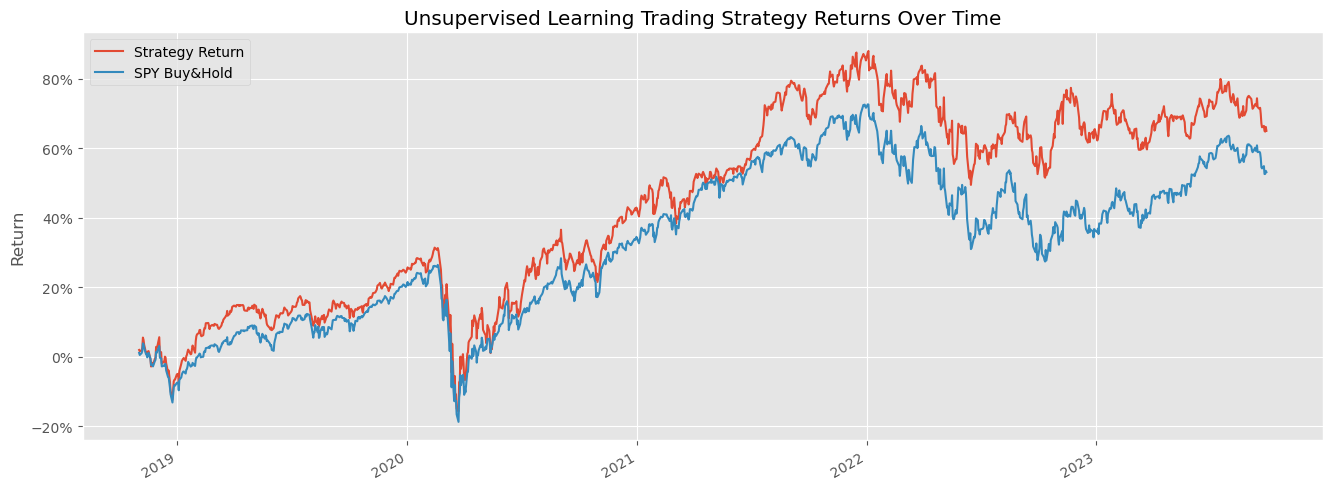

In [40]:
import matplotlib.ticker as mtick

plt.style.use('ggplot')

portfolio_cumulative_return = np.exp(np.log1p(portfolio_df).cumsum())-1

portfolio_cumulative_return[:'2023-09-29'].plot(figsize=(16,6))

plt.title('Unsupervised Learning Trading Strategy Returns Over Time')

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.ylabel('Return')

plt.show()
